In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

In [3]:
#Format days of the week to not appear alphabetically on visuals
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

In [4]:
# Source: http://web.mta.info/developers/turnstile.html
df1 = pd.concat(map(pd.read_csv, (['http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt',
                    'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt'])),ignore_index=True)

In [97]:
#Convert Date and Time into a more useable DateTime format.
def df_DateTime(df):
    df['DateTime'] = pd.to_datetime(df.DATE+' '+df.TIME)
    return df

#Record what day of the week each entry is from
def df_day_of_week(df):
    df['Day']=df.DateTime.dt.day_name()
    return df

#SCP represents a specific turnstile.
#C/A represents a control area. This is a bank of turnstiles.  
#Unit represents a remote unit. Usually a whole station, or an area in a complex station.
#We can combine all three to create a unique ID for any turnstile
def df_Unit_ID(df):
    df['Unit_ID'] = df.SCP+' '+df['C/A']+' '+df.UNIT
    return df

#Many station names appear unique, but are actually different locations. To give stations a unique identifier:
#Combine Station name, Division, and Linename
def df_station_id(df):
    df['station_id'] = df.STATION+' '+df.DIVISION+' '+df.LINENAME
    return df

#Rename Exits column to remove extra spaces
def rename_columns(df):
    df.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)
    return df

#Remove irregularities in reporting
def clean_desc(df):
    df = df[df.DESC == 'REGULAR']
    return df

#Calculate the entries/exits in a four hour period by finding the difference between rows
def df_four_hour(df):
    df['Four Hour Entries'] = df.groupby('Unit_ID').ENTRIES.diff()
    df['Four Hour Exits'] = df.groupby('Unit_ID').EXITS.diff()
    return df

#Replace NaN, negative values, and impossibly large values by the average of the turnstile
def df_clean_four_hour(df):
    df['Four Hour Entries'].fillna(-1, inplace=True)
    df['Four Hour Exits'].fillna(-1, inplace=True)
    df['Four Hour Entries'] = df.groupby(['TIME','C/A'])['Four Hour Entries'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    df['Four Hour Exits'] = df.groupby(['TIME','C/A'])['Four Hour Exits'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    return df

#Create a column for the total amount of traffic through a turnstile
def df_total_flow(df):
    df['Total Flow'] = df['Four Hour Entries']+df['Four Hour Exits']
    return df

In [6]:
df1 = df_DateTime(df1)
df1 = df_day_of_week(df1)
df1 = df_Unit_ID(df1)
df1 = rename_columns(df1)
df1 = df_four_hour(df1)
df1 = df_clean_four_hour(df1)
df1 = clean_desc(df1)
df1 = df_total_flow(df1)
df1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,Day,Unit_ID,Four Hour Entries,Four Hour Exits,Total Flow
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,Saturday,02-00-00 A002 R051,150.529703,48.537129,199.066832
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,Saturday,02-00-00 A002 R051,20.000000,7.000000,27.000000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,Saturday,02-00-00 A002 R051,23.000000,35.000000,58.000000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,Saturday,02-00-00 A002 R051,100.000000,76.000000,176.000000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,Saturday,02-00-00 A002 R051,259.000000,69.000000,328.000000


In [ ]:
df1 = df_station_id(df1)

In [8]:
#Find daily sum for each STATION for each day of the week
df1_daily = df1.groupby(['STATION','DATE'],as_index=False)['Total Flow'].sum()
df1_daily.head(20)

,STATION,DATE,Total Flow
0,1 AV,04/27/2019,15989.676471
1,1 AV,04/28/2019,12444.000000
2,1 AV,04/29/2019,36454.000000
3,1 AV,04/30/2019,39009.000000
4,1 AV,05/01/2019,40345.000000
5,1 AV,05/02/2019,40741.000000
6,1 AV,05/03/2019,42397.000000
7,1 AV,05/04/2019,17728.000000
8,1 AV,05/05/2019,13728.000000
9,1 AV,05/06/2019,36691.000000


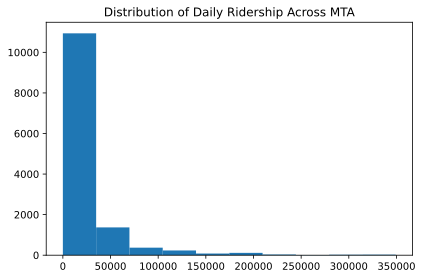

In [117]:
plt.hist(df1_daily['Total Flow'])
plt.title('Distribution of Daily Ridership Across MTA')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_daily_dist.svg',kind='svg')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

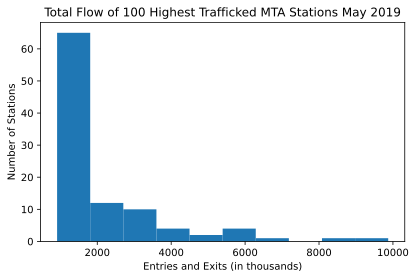

In [115]:
ridership = df1.groupby(['STATION'])['Total Flow'].sum()/1000
top_100 = ridership.sort_values(ascending=False).round(0).head(100)

plt.hist(top_100)
plt.title('Total Flow of 100 Highest Trafficked MTA Stations May 2019')
plt.xlabel('Entries and Exits (in thousands)')
plt.ylabel('Number of Stations')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_top100_dist.svg',kind='svg')
plt.show

In [13]:
top_20 = ridership.sort_values(ascending=False).round(0).head(20)

<function matplotlib.pyplot.show(*args, **kw)>

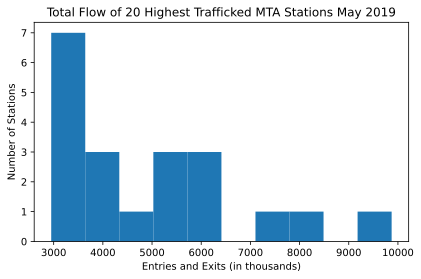

In [113]:
plt.hist(top_20)
plt.title('Total Flow of 20 Highest Trafficked MTA Stations May 2019')
plt.xlabel('Entries and Exits (in thousands)')
plt.ylabel('Number of Stations')
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_top20.svg',kind='svg')
plt.show

In [77]:
ridership = df1.groupby(['STATION','Day')['Total Flow'].sum()/1000
top_10 = ridership.sort_values(ascending=False).reset_index().head(10)
top_10

,STATION,Total Flow
0,34 ST-PENN STA,9872.320102
1,GRD CNTRL-42 ST,8283.118839
2,34 ST-HERALD SQ,7184.260678
3,14 ST-UNION SQ,6136.191787
4,TIMES SQ-42 ST,6036.652416
5,23 ST,5951.988277
6,42 ST-PORT AUTH,5694.885440
7,FULTON ST,5310.743000
8,86 ST,5119.460362
9,125 ST,4472.492055


<function matplotlib.pyplot.show(*args, **kw)>

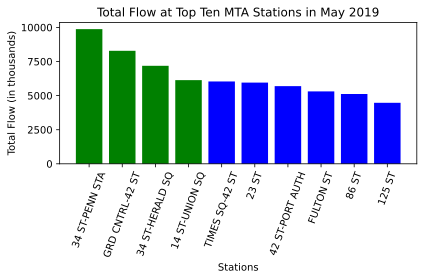

In [112]:
ticks_x = np.linspace(0,9,10)
ticks_y = np.linspace(0,10000,5)
plt.figure(figsize=[6,4])
plt.bar(top_10['STATION'],top_10['Total Flow'],color=['g','g','g','g','b','b','b','b','b','b'])
plt.title('Total Flow at Top Ten MTA Stations in May 2019')
plt.xlabel('Stations')
plt.ylabel('Total Flow (in thousands)')
plt.xticks(ticks_x,top_10['STATION'],rotation=70)
plt.yticks(ticks_y)
plt.tight_layout()
plt.savefig('OneDrive\Desktop\Metis\Projects\Project 1\mta_top10_colorcoded.svg',kind='svg')
plt.show

In [79]:
ridership = ridership.reset_index()
ridership.head()

,index,STATION,Total Flow
0,0,1 AV,1109.516676
1,1,103 ST,1626.619529
2,2,103 ST-CORONA,1083.448794
3,3,104 ST,207.297006
4,4,110 ST,627.729088


In [92]:
sum = ridership['Total Flow'].sum()
ridership.shape

(378, 4)

In [94]:
sum*1000

316085932.8091887

In [89]:
ridership['Percentage of Total Flow'] = (ridership['Total Flow']*100/sum).round(2)
ridership.sort_values(['Percentage of Total Flow'],ascending=False).head(40)

,index,STATION,Total Flow,Percentage of Total Flow
61,61,34 ST-PENN STA,9872.320102,3.12
232,232,GRD CNTRL-42 ST,8283.118839,2.62
59,59,34 ST-HERALD SQ,7184.260678,2.27
14,14,14 ST-UNION SQ,6136.191787,1.94
352,352,TIMES SQ-42 ST,6036.652416,1.91
46,46,23 ST,5951.988277,1.88
68,68,42 ST-PORT AUTH,5694.885440,1.80
225,225,FULTON ST,5310.743000,1.68
110,110,86 ST,5119.460362,1.62
9,9,125 ST,4472.492055,1.41


In [96]:
ridership.sort_values(['Percentage of Total Flow'],ascending=False)['Percentage of Total Flow'].head(5).sum()

11.86

In [63]:
station_zips = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
station_zips.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN


In [111]:
#When stations are divided to correctly represent the geography of New York, 

#Not ever row represents a new station, have to see if LINENAMEs correspond to new stations.
#e.g.: 34 ST-PENN STA is all one station-complex, BUT:
#Fulton is two stations, 125 is 4, Canal is 3, 23 St is 5 86 ST is 5

#Use as a check against top list of stations, to make sure that none are being overvalued

df1[(df1['STATION']=='23 ST')|
    (df1['STATION']=='86 ST')|
    (df1['STATION']=='FULTON ST')|
    (df1['STATION']=='125 ST')|
    (df1['STATION']=='CANAL ST')|
    (df1['STATION']=='34 ST-PENN STA')
   ].groupby(['STATION','DIVISION','LINENAME'])['Total Flow'].sum()*100/1000/sum

STATION         DIVISION  LINENAME
125 ST          IND       ACBD        0.545303
                IRT       1           0.158912
                          23          0.217464
                          456         0.493282
23 ST           BMT       NRW         0.347372
                IND       CE          0.381687
                          FM          0.418483
                IRT       1           0.254489
                          6           0.480997
34 ST-PENN STA  IND       ACE         1.535978
                IRT       123         0.666932
                          123ACE      0.920392
86 ST           BMT       N           0.042936
                          R           0.171030
                IND       BC          0.197753
                IRT       1           0.361913
                          456         0.846011
CANAL ST        BMT       JNQRZ6W     0.826412
                IND       ACE         0.376570
                IRT       1           0.117742
FULTON ST       BMT      